# Rainfall composite
* Wenchang Yang (wenchang@princeton.edu)
* Department of Geosciences, Princeton Univeristy

In [158]:
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]

from geoplots import mapplot, xticks2lon, yticks2lat
from climindex import get_mjo

from scipy.stats import ttest_1samp

In [12]:
%matplotlib inline

In [27]:
# data
ncfile = 'chirps-v2.0.days_p05.28E36E_02S06N.nc'
precip = xr.open_mfdataset(ncfile).precip.load().rename({'longitude': 'lon', 'latitude': 'lat'})
da = precip

In [39]:
# data: MJO
mjo = get_mjo()
mjo['time'] = mjo.time.to_index().shift(-12, 'H')

In [73]:
years = ('1981', '2017')
season = 'MAM'
yearseason = precip.time.sel(time=slice(*years)) \
    .pipe(lambda x: x[x['time.season']==season])
yearseason

<xarray.DataArray 'time' (time: 3404)>
array(['1981-03-01T00:00:00.000000000', '1981-03-02T00:00:00.000000000',
       '1981-03-03T00:00:00.000000000', ..., '2017-05-29T00:00:00.000000000',
       '2017-05-30T00:00:00.000000000', '2017-05-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1981-03-01 1981-03-02 1981-03-03 ...
Attributes:
    standard_name:  time
    axis:           T

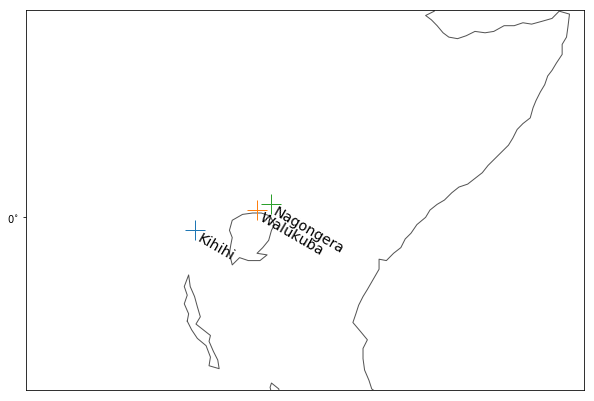

In [98]:
sites = [('Kihihi', -0.748889, 29.7003), # name, lat, lon
         ('Walukuba', 0.447222, 33.2367),
         ('Nagongera', .77, 34.0261)]
mapplot(lon=(20,52), lat=(-10,12))
for site in sites:
    plt.plot(site[2], site[1], marker='+', markersize=20)
    plt.text(site[2], site[1], site[0], 
             ha='left', va='top', fontsize='x-large', rotation=-30)

Text(0.5,1,'MAM rainfall climatology: 1981-2017')

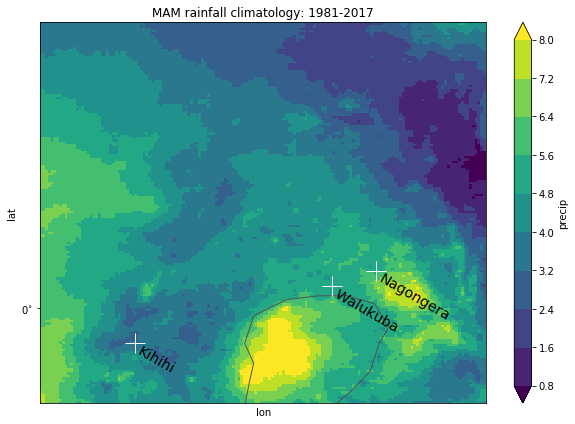

In [104]:
# fig: season climatology
da = precip
da.sel(time=yearseason).mean('time').plot(robust=True, levels=10)
mapplot()
for site in sites:
    plt.plot(site[2], site[1], marker='+', markersize=20, color='w')
    plt.text(site[2], site[1], site[0], 
             ha='left', va='top', color='k', fontsize='x-large', rotation=-30)
plt.title(f'{season} rainfall climatology: {years[0]}-{years[1]}')

In [240]:
# time series
tss = dict()
da = precip
for s, lat, lon in sites:
    tss[s] = da.sel(lon=lon, lat=lat, method='nearest')
    print(s, lat, '->', tss[s].lat.item(),';', lon, '->', tss[s].lon.item())
df = pd.DataFrame(tss, index=da.time)
df.head()
df.to_csv('rainfall.csv')

Kihihi -0.748889 -> -0.7250022888183594 ; 29.7003 -> 29.724990844726562
Walukuba 0.447222 -> 0.4249992370605469 ; 33.2367 -> 33.22499084472656
Nagongera 0.77 -> 0.7749977111816406 ; 34.0261 -> 34.024993896484375


Text(0.5,1,'')

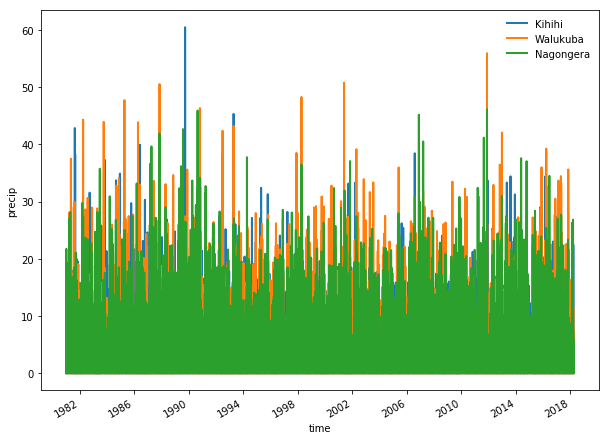

In [242]:
for s,lat,lon in sites:
    tss[s].plot(label=s)

plt.legend()
plt.title('')

## composite

In [125]:
# data: prcp composite for differnet MJO phases
das = dict()
pvalues = dict()
da = precip
season_clim = da.sel(time=yearseason).mean('time')
for i in range(1, 9):
    t = mjo.sel(time=yearseason).phase.pipe(lambda x: x[x==i]).time
    das[i] = da.sel(time=t) - season_clim
    tt, pvalues[i] = ttest_1samp(das[i], 0)


/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


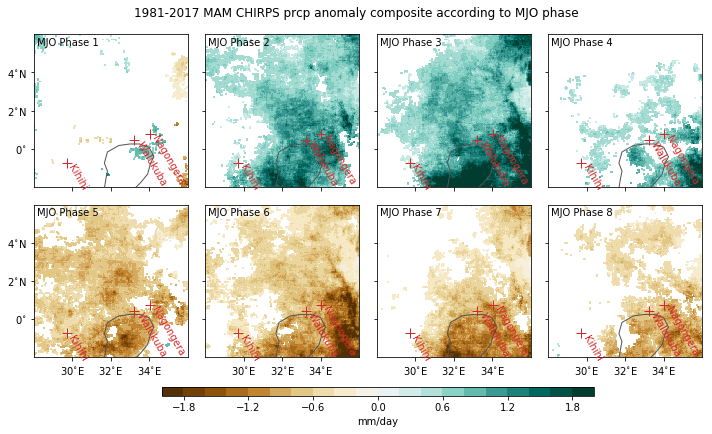

In [210]:
# fig: prcp composite of MJO phase
fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(10,6))
for i,ax in enumerate(axes.flat, start=1):
    plt.sca(ax)
    im = das[i].mean('time').where(pvalues[i]<=.05).plot(cmap='BrBG', 
                                                    robust=True, 
                                                    levels=np.arange(-2,2.1,.2),
                                                   add_colorbar=False)
    mapplot(lon=das[i].lon, lat=das[i].lat)
    for site in sites:
        plt.plot(site[2], site[1], marker='+', markersize=10, color='C3')
        plt.text(site[2], site[1], site[0], 
             ha='left', va='top', color='C3', rotation=-60)
    
    plt.text(.02, .98, f'MJO Phase {i}', ha='left', va='top', transform=ax.transAxes)
    
    plt.xlabel('')
    plt.ylabel('')
    

plt.sca(axes[1,0])
yticks2lat(range(0,6,2))
xticks2lon(range(30,36,2))

plt.suptitle(f'{years[0]}-{years[1]} {season} CHIRPS prcp anomaly composite according to MJO phase')

ax = fig.add_axes((.23,.08,.6,.02))
plt.colorbar(im, cax=ax, orientation='horizontal', label='mm/day')

plt.tight_layout(rect=(0,.1,1,.95))

## composite, 2011-2016

In [216]:
# data: prcp composite for differnet MJO phases
das = dict()
pvalues = dict()
da = precip
season_clim = da.sel(time=yearseason).mean('time')
years_shorter = ('2011', '2016')
for i in range(1, 9):
    t = mjo.sel(time=yearseason).sel(time=slice(*years_shorter)).phase.pipe(lambda x: x[x==i]).time
    das[i] = da.sel(time=t) - season_clim
    tt, pvalues[i] = ttest_1samp(das[i], 0)


/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


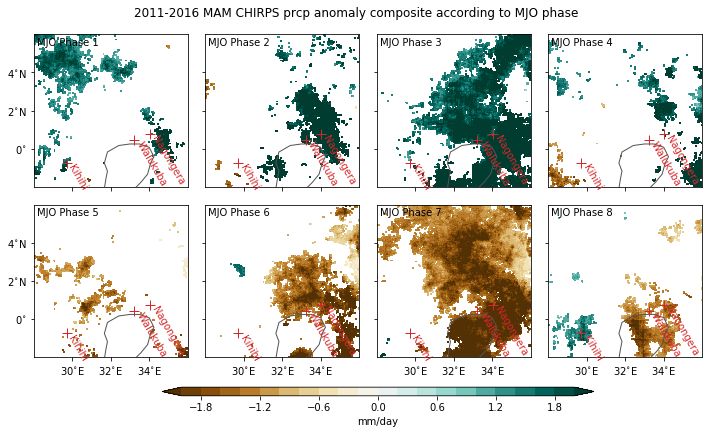

In [223]:
# fig: prcp composite of MJO phase
fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(10,6))
for i,ax in enumerate(axes.flat, start=1):
    plt.sca(ax)
    im = das[i].mean('time')  \
        .where(pvalues[i]<.05) \
        .plot(cmap='BrBG', 
        robust=True, 
        levels=np.arange(-2,2.1,.2),
        add_colorbar=False)
    mapplot(lon=das[i].lon, lat=das[i].lat)
    for site in sites:
        plt.plot(site[2], site[1], marker='+', markersize=10, color='C3')
        plt.text(site[2], site[1], site[0], 
             ha='left', va='top', color='C3', rotation=-60)
    
    plt.text(.02, .98, f'MJO Phase {i}', ha='left', va='top', transform=ax.transAxes)
    
    plt.xlabel('')
    plt.ylabel('')
    

plt.sca(axes[1,0])
yticks2lat(range(0,6,2))
xticks2lon(range(30,36,2))

plt.suptitle(f'{years_shorter[0]}-{years_shorter[1]} {season} CHIRPS prcp anomaly composite according to MJO phase')

ax = fig.add_axes((.23,.08,.6,.02))
plt.colorbar(im, cax=ax, orientation='horizontal', label='mm/day')

plt.tight_layout(rect=(0,.1,1,.95))

## composite, MJO amplitude > 1

In [211]:
# data: prcp composite for differnet MJO phases (amplitude >1)
das = dict()
pvalues = dict()
da = precip
season_clim = da.sel(time=yearseason).mean('time')
for i in range(1, 9):
    t = mjo.sel(time=yearseason).pipe(lambda x: x.time[(x.phase==i) & (x.amplitude>=1)])
    das[i] = da.sel(time=t) - season_clim
    tt, pvalues[i] = ttest_1samp(das[i], 0)


/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


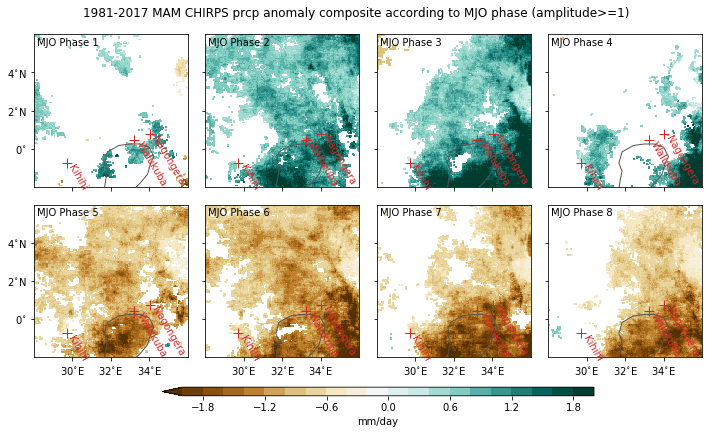

In [214]:
# fig: prcp composite of MJO phase
fig, axes = plt.subplots(2,4, sharex=True, sharey=True, figsize=(10,6))
for i,ax in enumerate(axes.flat, start=1):
    plt.sca(ax)
    im = das[i].mean('time').where(pvalues[i]<=.05).plot(cmap='BrBG', 
                                                    robust=True, 
                                                    levels=np.arange(-2,2.1,.2),
                                                   add_colorbar=False)
    mapplot(lon=das[i].lon, lat=das[i].lat)
    for site in sites:
        plt.plot(site[2], site[1], marker='+', markersize=10, color='C3')
        plt.text(site[2], site[1], site[0], 
             ha='left', va='top', color='C3', rotation=-60)
    
    plt.text(.02, .98, f'MJO Phase {i}', ha='left', va='top', transform=ax.transAxes)
    
    plt.xlabel('')
    plt.ylabel('')
    

plt.sca(axes[1,0])
yticks2lat(range(0,6,2))
xticks2lon(range(30,36,2))

plt.suptitle(f'{years[0]}-{years[1]} {season} CHIRPS prcp anomaly composite according to MJO phase (amplitude>=1)')

ax = fig.add_axes((.23,.08,.6,.02))
plt.colorbar(im, cax=ax, orientation='horizontal', label='mm/day')

plt.tight_layout(rect=(0,.1,1,.95))